# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

dpi = 50

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/MP_dataset',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

    # Defining target factor
    target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

Number of training   graphs: 35600
Number of validation graphs: 4450
Number of testing    graphs: 4450


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [7]:
model = clm.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

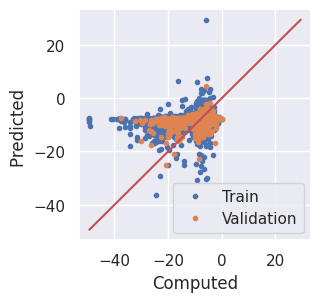

Epoch: 1, Train MAE: 3.3792, Val MAE: 3.2322
Epoch: 2, Train MAE: 3.2932, Val MAE: 3.1986
Epoch: 3, Train MAE: 3.2646, Val MAE: 3.1847
Epoch: 4, Train MAE: 3.2498, Val MAE: 3.1726
Epoch: 5, Train MAE: 3.2289, Val MAE: 3.1536
Epoch: 6, Train MAE: 3.2057, Val MAE: 3.1557
Epoch: 7, Train MAE: 3.1983, Val MAE: 3.1299
Epoch: 8, Train MAE: 3.1911, Val MAE: 3.1250
Epoch: 9, Train MAE: 3.1705, Val MAE: 3.1190
Epoch: 10, Train MAE: 3.1697, Val MAE: 3.1280


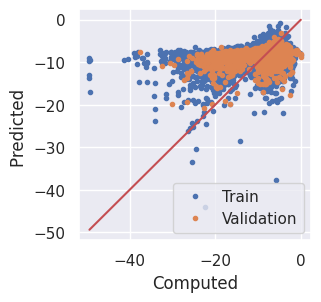

Epoch: 11, Train MAE: 3.1746, Val MAE: 3.1006
Epoch: 12, Train MAE: 3.1647, Val MAE: 3.1125
Epoch: 13, Train MAE: 3.1512, Val MAE: 3.1022
Epoch: 14, Train MAE: 3.1377, Val MAE: 3.1001
Epoch: 15, Train MAE: 3.1336, Val MAE: 3.0948
Epoch: 16, Train MAE: 3.1292, Val MAE: 3.0775
Epoch: 17, Train MAE: 3.1128, Val MAE: 3.0796
Epoch: 18, Train MAE: 3.1096, Val MAE: 3.0752
Epoch: 19, Train MAE: 3.0990, Val MAE: 3.0914
Epoch: 20, Train MAE: 3.1304, Val MAE: 3.0701


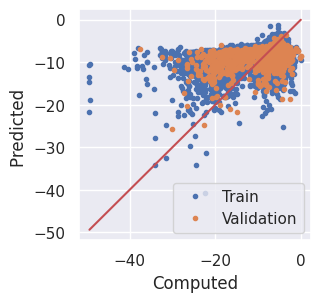

Epoch: 21, Train MAE: 3.1027, Val MAE: 3.0441
Epoch: 22, Train MAE: 3.0849, Val MAE: 3.0556
Epoch: 23, Train MAE: 3.0830, Val MAE: 3.0482
Epoch: 24, Train MAE: 3.0794, Val MAE: 3.0361
Epoch: 25, Train MAE: 3.0741, Val MAE: 3.0348
Epoch: 26, Train MAE: 3.0633, Val MAE: 3.0795
Epoch: 27, Train MAE: 3.0750, Val MAE: 3.0464
Epoch: 28, Train MAE: 3.0595, Val MAE: 3.0388
Epoch: 29, Train MAE: 3.0694, Val MAE: 3.0209
Epoch: 30, Train MAE: 3.0639, Val MAE: 3.0084


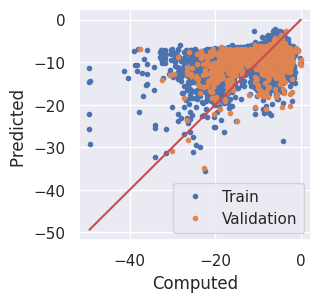

Epoch: 31, Train MAE: 3.0508, Val MAE: 3.0248
Epoch: 32, Train MAE: 3.0377, Val MAE: 3.0398
Epoch: 33, Train MAE: 3.0792, Val MAE: 3.0404
Epoch: 34, Train MAE: 3.0380, Val MAE: 3.0066
Epoch: 35, Train MAE: 3.0320, Val MAE: 3.0249
Epoch: 36, Train MAE: 3.0229, Val MAE: 3.0026
Epoch: 37, Train MAE: 3.0261, Val MAE: 2.9885
Epoch: 38, Train MAE: 3.0028, Val MAE: 2.9862
Epoch: 39, Train MAE: 3.0129, Val MAE: 3.0351
Epoch: 40, Train MAE: 3.0322, Val MAE: 2.9905


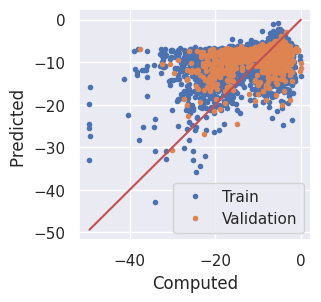

Epoch: 41, Train MAE: 3.0039, Val MAE: 2.9923
Epoch: 42, Train MAE: 2.9967, Val MAE: 2.9872
Epoch: 43, Train MAE: 2.9982, Val MAE: 2.9946
Epoch: 44, Train MAE: 2.9910, Val MAE: 2.9828
Epoch: 45, Train MAE: 2.9918, Val MAE: 2.9952
Epoch: 46, Train MAE: 2.9896, Val MAE: 2.9863
Epoch: 47, Train MAE: 3.0098, Val MAE: 2.9553
Epoch: 48, Train MAE: 2.9978, Val MAE: 2.9818
Epoch: 49, Train MAE: 2.9835, Val MAE: 2.9879
Epoch: 50, Train MAE: 2.9779, Val MAE: 2.9446


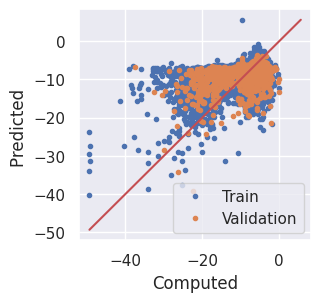

Epoch: 51, Train MAE: 2.9660, Val MAE: 2.9950
Epoch: 52, Train MAE: 2.9614, Val MAE: 2.9658
Epoch: 53, Train MAE: 2.9778, Val MAE: 3.0072
Epoch: 54, Train MAE: 3.0263, Val MAE: 2.9669
Epoch: 55, Train MAE: 2.9653, Val MAE: 2.9454
Epoch: 56, Train MAE: 2.9907, Val MAE: 2.9604
Epoch: 57, Train MAE: 2.9575, Val MAE: 2.9575
Epoch: 58, Train MAE: 2.9531, Val MAE: 2.9656
Epoch: 59, Train MAE: 2.9546, Val MAE: 2.9623
Epoch: 60, Train MAE: 2.9478, Val MAE: 2.9289


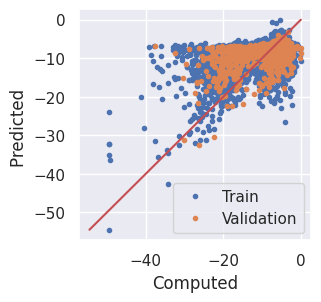

Epoch: 61, Train MAE: 2.9390, Val MAE: 2.9359
Epoch: 62, Train MAE: 2.9240, Val MAE: 2.9295
Epoch: 63, Train MAE: 2.9246, Val MAE: 2.9600
Epoch: 64, Train MAE: 2.9492, Val MAE: 2.9398
Epoch: 65, Train MAE: 2.9501, Val MAE: 2.9419
Epoch: 66, Train MAE: 2.9375, Val MAE: 2.9435
Epoch: 67, Train MAE: 2.9271, Val MAE: 2.9421
Epoch: 68, Train MAE: 2.9158, Val MAE: 2.9321
Epoch: 69, Train MAE: 2.9189, Val MAE: 2.9228
Epoch: 70, Train MAE: 2.9223, Val MAE: 2.9287


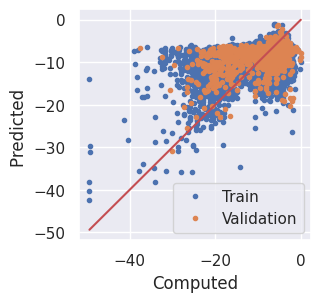

Epoch: 71, Train MAE: 2.9148, Val MAE: 2.9812
Epoch: 72, Train MAE: 2.9477, Val MAE: 2.9641
Epoch: 73, Train MAE: 2.9193, Val MAE: 2.9335
Epoch: 74, Train MAE: 2.9172, Val MAE: 2.9302
Epoch: 75, Train MAE: 2.9213, Val MAE: 2.9511
Epoch: 76, Train MAE: 2.9074, Val MAE: 2.9140
Epoch: 77, Train MAE: 2.9109, Val MAE: 2.9270
Epoch: 78, Train MAE: 2.9269, Val MAE: 2.9159
Epoch: 79, Train MAE: 2.8924, Val MAE: 2.9201
Epoch: 80, Train MAE: 2.9044, Val MAE: 2.9126


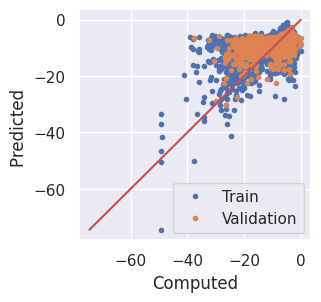

Epoch: 81, Train MAE: 2.8899, Val MAE: 2.9484
Epoch: 82, Train MAE: 2.8974, Val MAE: 2.9238
Epoch: 83, Train MAE: 2.8921, Val MAE: 2.9123
Epoch: 84, Train MAE: 2.8847, Val MAE: 2.9083
Epoch: 85, Train MAE: 2.8919, Val MAE: 2.9115
Epoch: 86, Train MAE: 2.8747, Val MAE: 2.8947
Epoch: 87, Train MAE: 2.8776, Val MAE: 2.9647
Epoch: 88, Train MAE: 2.8948, Val MAE: 2.9350
Epoch: 89, Train MAE: 2.8754, Val MAE: 2.9335
Epoch: 90, Train MAE: 2.8905, Val MAE: 2.9761


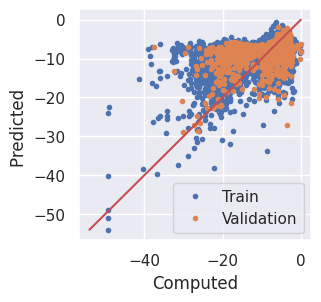

Epoch: 91, Train MAE: 2.9012, Val MAE: 2.9367
Epoch: 92, Train MAE: 2.8709, Val MAE: 2.9627
Epoch: 93, Train MAE: 2.8628, Val MAE: 2.9362
Epoch: 94, Train MAE: 2.8493, Val MAE: 2.9428
Epoch: 95, Train MAE: 2.8644, Val MAE: 2.9410
Epoch: 96, Train MAE: 2.8817, Val MAE: 2.9589
Epoch: 97, Train MAE: 2.8658, Val MAE: 2.9459
Epoch: 98, Train MAE: 2.8555, Val MAE: 2.9166
Epoch: 99, Train MAE: 2.8448, Val MAE: 2.9106
Epoch: 100, Train MAE: 2.8707, Val MAE: 2.9168


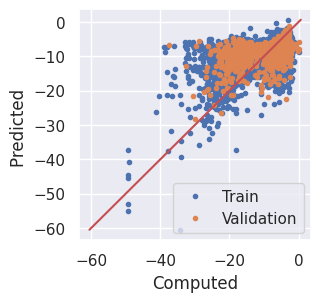

Epoch: 101, Train MAE: 2.8461, Val MAE: 2.9035
Epoch: 102, Train MAE: 2.8416, Val MAE: 2.9105
Epoch: 103, Train MAE: 2.8472, Val MAE: 2.9124
Epoch: 104, Train MAE: 2.8305, Val MAE: 2.9224
Epoch: 105, Train MAE: 2.8508, Val MAE: 2.9634
Epoch: 106, Train MAE: 2.8946, Val MAE: 2.9437
Epoch: 107, Train MAE: 2.8555, Val MAE: 2.9239
Epoch: 108, Train MAE: 2.8554, Val MAE: 2.9021
Epoch: 109, Train MAE: 2.8358, Val MAE: 2.9407
Epoch: 110, Train MAE: 2.8332, Val MAE: 2.9302


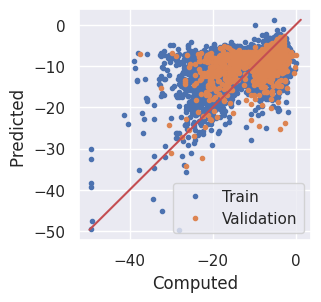

Epoch: 111, Train MAE: 2.8297, Val MAE: 2.9207
Epoch: 112, Train MAE: 2.8136, Val MAE: 2.9336
Epoch: 113, Train MAE: 2.8285, Val MAE: 2.9311
Epoch: 114, Train MAE: 2.8515, Val MAE: 2.9200
Epoch: 115, Train MAE: 2.8271, Val MAE: 2.9273
Epoch: 116, Train MAE: 2.8166, Val MAE: 2.8930
Epoch: 117, Train MAE: 2.8053, Val MAE: 2.9254
Epoch: 118, Train MAE: 2.8477, Val MAE: 2.9255
Epoch: 119, Train MAE: 2.8166, Val MAE: 2.9414
Epoch: 120, Train MAE: 2.8284, Val MAE: 2.9037


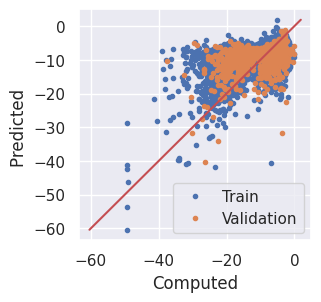

Epoch: 121, Train MAE: 2.8140, Val MAE: 2.9626
Epoch: 122, Train MAE: 2.8447, Val MAE: 2.9121
Epoch: 123, Train MAE: 2.8131, Val MAE: 2.9486
Epoch: 124, Train MAE: 2.8171, Val MAE: 2.9270
Epoch: 125, Train MAE: 2.8110, Val MAE: 2.9163
Epoch: 126, Train MAE: 2.8068, Val MAE: 2.9195
Epoch: 127, Train MAE: 2.8004, Val MAE: 2.9085
Epoch: 128, Train MAE: 2.7994, Val MAE: 2.9043
Epoch: 129, Train MAE: 2.8213, Val MAE: 2.9151
Epoch: 130, Train MAE: 2.7850, Val MAE: 2.9079


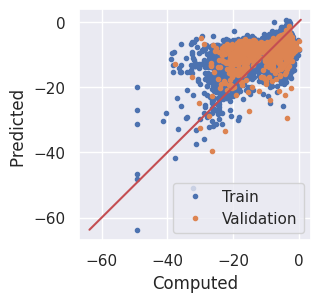

Epoch: 131, Train MAE: 2.8036, Val MAE: 2.9181
Epoch: 132, Train MAE: 2.7782, Val MAE: 2.8975
Epoch: 133, Train MAE: 2.7871, Val MAE: 2.9121
Epoch: 134, Train MAE: 2.7904, Val MAE: 2.9031
Epoch: 135, Train MAE: 2.8047, Val MAE: 2.9248
Epoch: 136, Train MAE: 2.8008, Val MAE: 2.9192
Epoch: 137, Train MAE: 2.7777, Val MAE: 2.8963
Epoch: 138, Train MAE: 2.7807, Val MAE: 2.8791
Epoch: 139, Train MAE: 2.7697, Val MAE: 2.9028
Epoch: 140, Train MAE: 2.7529, Val MAE: 2.8909


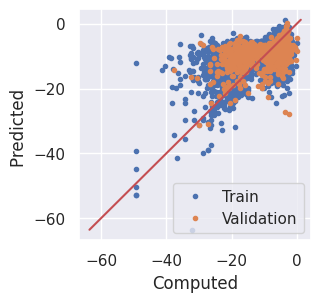

Epoch: 141, Train MAE: 2.8142, Val MAE: 2.9347
Epoch: 142, Train MAE: 2.7853, Val MAE: 2.8877
Epoch: 143, Train MAE: 2.7727, Val MAE: 2.9055
Epoch: 144, Train MAE: 2.7601, Val MAE: 2.8905
Epoch: 145, Train MAE: 2.7775, Val MAE: 2.8994
Epoch: 146, Train MAE: 2.7659, Val MAE: 2.9047
Epoch: 147, Train MAE: 2.7732, Val MAE: 2.8945
Epoch: 148, Train MAE: 2.7697, Val MAE: 2.9121
Epoch: 149, Train MAE: 2.7930, Val MAE: 2.8886
Epoch: 150, Train MAE: 2.7458, Val MAE: 2.9242


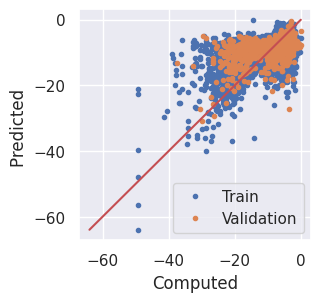

Epoch: 151, Train MAE: 2.7827, Val MAE: 2.8853
Epoch: 152, Train MAE: 2.7753, Val MAE: 2.8884
Epoch: 153, Train MAE: 2.7698, Val MAE: 2.9553
Epoch: 154, Train MAE: 2.7449, Val MAE: 2.8744
Epoch: 155, Train MAE: 2.7412, Val MAE: 2.9144
Epoch: 156, Train MAE: 2.7805, Val MAE: 2.8809
Epoch: 157, Train MAE: 2.7495, Val MAE: 2.8980
Epoch: 158, Train MAE: 2.7733, Val MAE: 2.9187
Epoch: 159, Train MAE: 2.7373, Val MAE: 2.8857
Epoch: 160, Train MAE: 2.7454, Val MAE: 2.8960


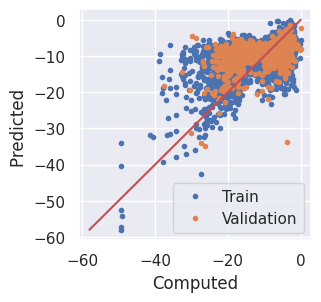

Epoch: 161, Train MAE: 2.7411, Val MAE: 2.8722
Epoch: 162, Train MAE: 2.7419, Val MAE: 2.9238
Epoch: 163, Train MAE: 2.7407, Val MAE: 2.9072
Epoch: 164, Train MAE: 2.7537, Val MAE: 2.9140
Epoch: 165, Train MAE: 2.7180, Val MAE: 2.9130
Epoch: 166, Train MAE: 2.7450, Val MAE: 2.9113
Epoch: 167, Train MAE: 2.7315, Val MAE: 2.8843
Epoch: 168, Train MAE: 2.7248, Val MAE: 2.8873
Epoch: 169, Train MAE: 2.7258, Val MAE: 2.9019
Epoch: 170, Train MAE: 2.7763, Val MAE: 2.9564


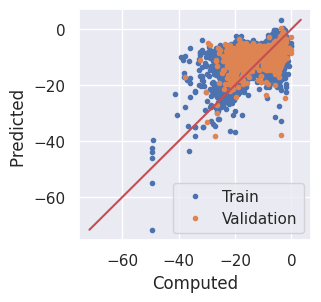

Epoch: 171, Train MAE: 2.7751, Val MAE: 2.9124
Epoch: 172, Train MAE: 2.7249, Val MAE: 2.9096
Epoch: 173, Train MAE: 2.7200, Val MAE: 2.9592
Epoch: 174, Train MAE: 2.7314, Val MAE: 2.9292
Epoch: 175, Train MAE: 2.7242, Val MAE: 2.8998
Epoch: 176, Train MAE: 2.7362, Val MAE: 2.8803
Epoch: 177, Train MAE: 2.7108, Val MAE: 2.9349
Epoch: 178, Train MAE: 2.7193, Val MAE: 2.9250
Epoch: 179, Train MAE: 2.7052, Val MAE: 2.9067
Epoch: 180, Train MAE: 2.7184, Val MAE: 2.8899


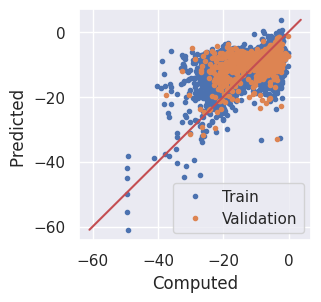

Epoch: 181, Train MAE: 2.7361, Val MAE: 2.9013
Epoch: 182, Train MAE: 2.7051, Val MAE: 2.9114
Epoch: 183, Train MAE: 2.7253, Val MAE: 2.8790
Epoch: 184, Train MAE: 2.7284, Val MAE: 2.8633
Epoch: 185, Train MAE: 2.7488, Val MAE: 2.8931
Epoch: 186, Train MAE: 2.7120, Val MAE: 2.8863
Epoch: 187, Train MAE: 2.6998, Val MAE: 2.9285
Epoch: 188, Train MAE: 2.7824, Val MAE: 2.8870
Epoch: 189, Train MAE: 2.7276, Val MAE: 2.8593
Epoch: 190, Train MAE: 2.7201, Val MAE: 2.9007


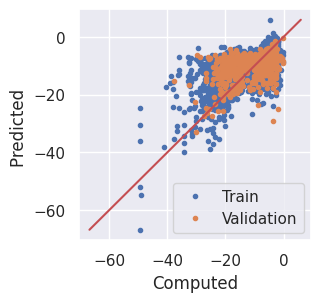

Epoch: 191, Train MAE: 2.7107, Val MAE: 2.8993
Epoch: 192, Train MAE: 2.7144, Val MAE: 2.9062
Epoch: 193, Train MAE: 2.7226, Val MAE: 2.9076
Epoch: 194, Train MAE: 2.7121, Val MAE: 2.9167
Epoch: 195, Train MAE: 2.6925, Val MAE: 2.8831
Epoch: 196, Train MAE: 2.7056, Val MAE: 2.8763
Epoch: 197, Train MAE: 2.6953, Val MAE: 2.8978
Epoch: 198, Train MAE: 2.6739, Val MAE: 2.9559
Epoch: 199, Train MAE: 2.7345, Val MAE: 2.8857
Epoch: 200, Train MAE: 2.7035, Val MAE: 2.9209


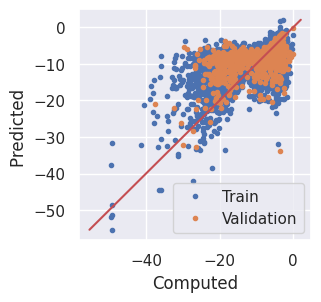

Epoch: 201, Train MAE: 2.7248, Val MAE: 2.9032
Epoch: 202, Train MAE: 2.7019, Val MAE: 2.8943
Epoch: 203, Train MAE: 2.6926, Val MAE: 2.8753
Epoch: 204, Train MAE: 2.6988, Val MAE: 2.8908
Epoch: 205, Train MAE: 2.7126, Val MAE: 2.8909
Epoch: 206, Train MAE: 2.7026, Val MAE: 2.9552
Epoch: 207, Train MAE: 2.6797, Val MAE: 2.8972
Epoch: 208, Train MAE: 2.6927, Val MAE: 2.8932
Epoch: 209, Train MAE: 2.6885, Val MAE: 2.9335
Epoch: 210, Train MAE: 2.6627, Val MAE: 2.9281


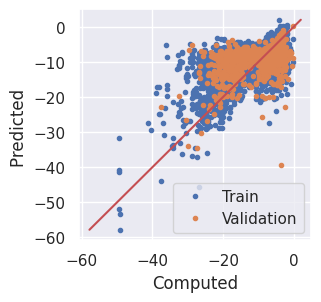

Epoch: 211, Train MAE: 2.6799, Val MAE: 2.9144
Epoch: 212, Train MAE: 2.7017, Val MAE: 2.9273
Epoch: 213, Train MAE: 2.7041, Val MAE: 2.9214
Epoch: 214, Train MAE: 2.7025, Val MAE: 2.9067
Epoch: 215, Train MAE: 2.6831, Val MAE: 2.8848
Epoch: 216, Train MAE: 2.6691, Val MAE: 2.9237
Epoch: 217, Train MAE: 2.6989, Val MAE: 2.9129
Epoch: 218, Train MAE: 2.7035, Val MAE: 2.8770
Epoch: 219, Train MAE: 2.7003, Val MAE: 2.8935
Epoch: 220, Train MAE: 2.6765, Val MAE: 2.9051


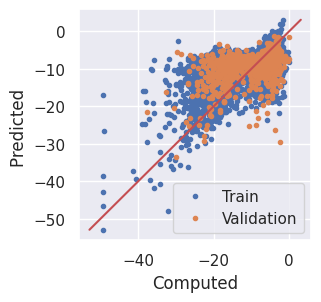

Epoch: 221, Train MAE: 2.6497, Val MAE: 2.9230
Epoch: 222, Train MAE: 2.6837, Val MAE: 2.9169
Epoch: 223, Train MAE: 2.6670, Val MAE: 2.9097
Epoch: 224, Train MAE: 2.6605, Val MAE: 2.8707
Epoch: 225, Train MAE: 2.6568, Val MAE: 2.9084
Epoch: 226, Train MAE: 2.6565, Val MAE: 2.8689
Epoch: 227, Train MAE: 2.6584, Val MAE: 2.8825
Epoch: 228, Train MAE: 2.6548, Val MAE: 2.8663
Epoch: 229, Train MAE: 2.6786, Val MAE: 2.8981
Epoch: 230, Train MAE: 2.6842, Val MAE: 2.8989


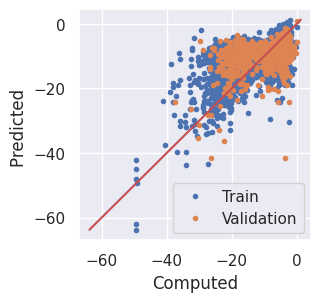

Epoch: 231, Train MAE: 2.6497, Val MAE: 2.9887
Epoch: 232, Train MAE: 2.6887, Val MAE: 2.9250
Epoch: 233, Train MAE: 2.6591, Val MAE: 2.9166
Epoch: 234, Train MAE: 2.6796, Val MAE: 2.9239
Epoch: 235, Train MAE: 2.6739, Val MAE: 2.8635
Epoch: 236, Train MAE: 2.6483, Val MAE: 2.8668
Epoch: 237, Train MAE: 2.6614, Val MAE: 2.8824
Epoch: 238, Train MAE: 2.6722, Val MAE: 2.8881
Epoch: 239, Train MAE: 2.6547, Val MAE: 2.8682
Epoch: 240, Train MAE: 2.6575, Val MAE: 2.8545


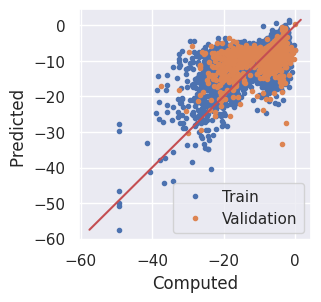

Epoch: 241, Train MAE: 2.6397, Val MAE: 2.8947
Epoch: 242, Train MAE: 2.6561, Val MAE: 2.9268
Epoch: 243, Train MAE: 2.6523, Val MAE: 2.9111
Epoch: 244, Train MAE: 2.6273, Val MAE: 2.8819
Epoch: 245, Train MAE: 2.6747, Val MAE: 2.8860
Epoch: 246, Train MAE: 2.6270, Val MAE: 2.9153
Epoch: 247, Train MAE: 2.6450, Val MAE: 2.8766
Epoch: 248, Train MAE: 2.7258, Val MAE: 2.9230
Epoch: 249, Train MAE: 2.7204, Val MAE: 2.8851
Epoch: 250, Train MAE: 2.6567, Val MAE: 2.9140


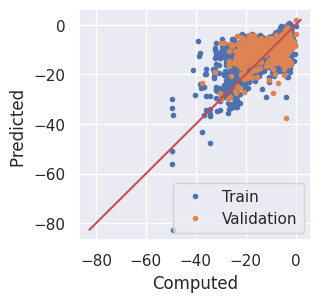

Epoch: 251, Train MAE: 2.6501, Val MAE: 2.9037
Epoch: 252, Train MAE: 2.6664, Val MAE: 2.9136
Epoch: 253, Train MAE: 2.6387, Val MAE: 2.8641
Epoch: 254, Train MAE: 2.6336, Val MAE: 2.8868
Epoch: 255, Train MAE: 2.6217, Val MAE: 2.8650
Epoch: 256, Train MAE: 2.6279, Val MAE: 2.8522
Epoch: 257, Train MAE: 2.6508, Val MAE: 2.9244
Epoch: 258, Train MAE: 2.6662, Val MAE: 2.9022
Epoch: 259, Train MAE: 2.6216, Val MAE: 2.9253
Epoch: 260, Train MAE: 2.6405, Val MAE: 2.8604


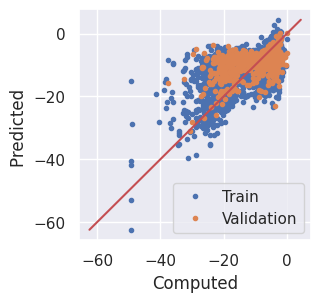

Epoch: 261, Train MAE: 2.6504, Val MAE: 2.8595
Epoch: 262, Train MAE: 2.5966, Val MAE: 2.9015
Epoch: 263, Train MAE: 2.6194, Val MAE: 2.8396
Epoch: 264, Train MAE: 2.6138, Val MAE: 2.9027
Epoch: 265, Train MAE: 2.6371, Val MAE: 2.8633
Epoch: 266, Train MAE: 2.6376, Val MAE: 2.8965
Epoch: 267, Train MAE: 2.6383, Val MAE: 2.9283
Epoch: 268, Train MAE: 2.6352, Val MAE: 2.8762
Epoch: 269, Train MAE: 2.6738, Val MAE: 2.8354
Epoch: 270, Train MAE: 2.6554, Val MAE: 2.8604


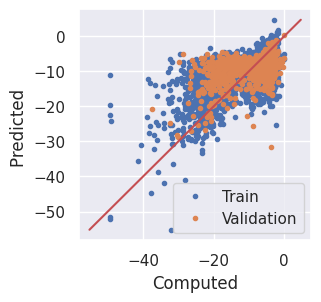

Epoch: 271, Train MAE: 2.6589, Val MAE: 2.8636
Epoch: 272, Train MAE: 2.6593, Val MAE: 2.8686
Epoch: 273, Train MAE: 2.6296, Val MAE: 2.8700
Epoch: 274, Train MAE: 2.6208, Val MAE: 2.8755
Epoch: 275, Train MAE: 2.6322, Val MAE: 2.8795
Epoch: 276, Train MAE: 2.6147, Val MAE: 2.9097
Epoch: 277, Train MAE: 2.6316, Val MAE: 2.9168
Epoch: 278, Train MAE: 2.6245, Val MAE: 2.8708
Epoch: 279, Train MAE: 2.6443, Val MAE: 2.8819
Epoch: 280, Train MAE: 2.6090, Val MAE: 2.9034


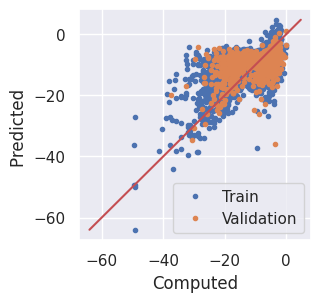

Epoch: 281, Train MAE: 2.6262, Val MAE: 2.8777
Epoch: 282, Train MAE: 2.6475, Val MAE: 2.8885
Epoch: 283, Train MAE: 2.7086, Val MAE: 2.9340
Epoch: 284, Train MAE: 2.7165, Val MAE: 2.8799
Epoch: 285, Train MAE: 2.6566, Val MAE: 2.8559
Epoch: 286, Train MAE: 2.6148, Val MAE: 2.8526
Epoch: 287, Train MAE: 2.6171, Val MAE: 2.8960
Epoch: 288, Train MAE: 2.6148, Val MAE: 2.8820
Epoch: 289, Train MAE: 2.6186, Val MAE: 2.9154
Epoch: 290, Train MAE: 2.6123, Val MAE: 2.9034


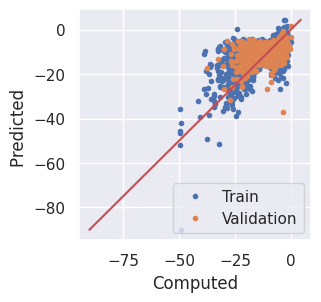

Epoch: 291, Train MAE: 2.6348, Val MAE: 2.8705
Epoch: 292, Train MAE: 2.6211, Val MAE: 2.8780
Epoch: 293, Train MAE: 2.6230, Val MAE: 2.8511
Epoch: 294, Train MAE: 2.6301, Val MAE: 2.8596
Epoch: 295, Train MAE: 2.6048, Val MAE: 2.8618
Epoch: 296, Train MAE: 2.6269, Val MAE: 2.8250
Epoch: 297, Train MAE: 2.6082, Val MAE: 2.8698
Epoch: 298, Train MAE: 2.5960, Val MAE: 2.8701
Epoch: 299, Train MAE: 2.6239, Val MAE: 2.8350
Epoch: 300, Train MAE: 2.5943, Val MAE: 2.8319


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%10 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

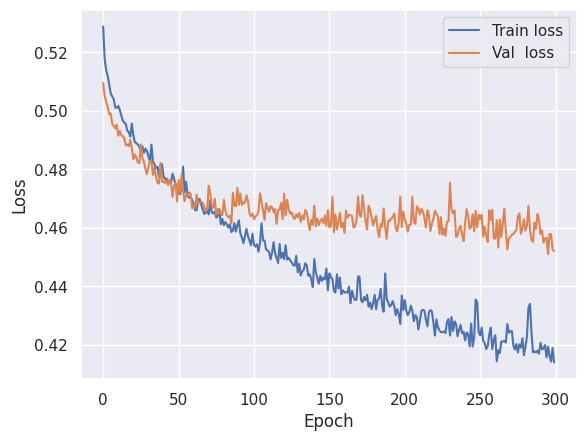

In [10]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [11]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(files_names['model_name'], map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

/tmp/ipykernel_566286/1424548799.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files_names['model_name'], map_location=torch.device(de

GCNN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 32)
  (linconv1): Linear(in_features=32, out_features=32, bias=True)
  (linconv2): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

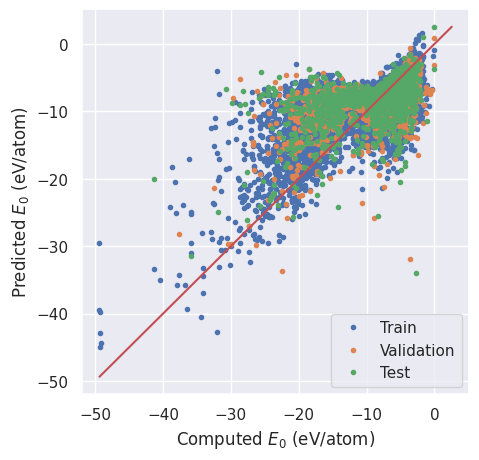

Train MAE: 2.4459, Val MAE: 2.8250, Test MAE: 2.9204


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor.to(device),
                                                              standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [13]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor.to(device),
                                            standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

array([ 0.03683805,  0.6792693 ,  2.354179  , ..., -0.95451975,
       -0.9230375 , -2.5769758 ], dtype=float32)

In [14]:
# Generate dictionary with uncertainty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(files_names['uncert_data_name'], 'w') as json_file:
    json.dump(uncertainty_data, json_file)